# De Bruijn shuffle sequence generator

In [6]:
from datetime import date
from pycltools.pycltools import jprint

jprint('Adrien Leger / EMBL EBI', bold=True, size=150)
jprint('Starting date : 2019_02_12', bold=True, italic=True, size=125)
jprint('Last modification date : {}_{:02}_{:02}'.format(date.today().year, date.today().month, date.today().day), bold=True, italic=True, size=125)

## Imports

In [7]:
# Standard lib imports
import os
from datetime import date
from collections import *
from random import *
from glob import glob, iglob
from shutil import rmtree
import itertools
from pprint import pprint as pp
import gzip

# Generic third party imports
from pycltools.pycltools import *
import pysam
import pyfaidx
from tqdm import tnrange, tqdm

# Ploting lib imports
import matplotlib.pyplot as pl
import seaborn as sns
%matplotlib inline

# Data wrangling lib imports
import pandas as pd
import numpy as np
import scipy as sp
pd.options.display.max_colwidth = 200
pd.options.display.max_columns = 200

## Generate basic De Bruijn sequence

**Basic De Bruijn function adapted from Wikipedia (https://en.wikipedia.org/wiki/De_Bruijn_sequence)**

In [8]:
def de_bruijn (alphabet, kmer_len):
    """
    De Bruijn sequence for alphabet and subsequences of length n.
    """
    k = len(alphabet)
    a = np.zeros(k*kmer_len, dtype=np.int)
    seq_list = []
    
    def db (t, p):
        # Recursive function to create the de bruijn sequence
        if t > kmer_len:
            if kmer_len % p == 0:
                seq_list.extend (a[1:p+1])
        else:
            a[t] = a[t - p]
            db(t+1, p)
            for j in range (a[t-p]+1, k):
                a[t] = j
                db(t+1, t)
    db(1, 1)
    return "".join(alphabet[i] for i in seq_list)

**Test de_bruijn function**

In [122]:
seq = de_bruijn (alphabet=["A","G","T","C"], kmer_len=5)
print(seq)

# Calculate theoritical number of kmers
possible_kmers = pow(len(alphabet),kmer_len)
print(f"Possible kmer sequences:{possible_kmers}")

# Count occurence of each kmer in sequence 
c = Counter()
seq_wrap = seq + seq[:kmer_len]
for i in range(len(seq)):
    c[seq_wrap[i:i+kmer_len]]+=1
print(f"kmer found in De Bruijn Sequence :{len(c)}")

# Bin kmer occurence count 
cc = Counter()
for i in c.values():
    cc[i]+=1
for i, j in cc.items():
    print (f"Kmer count:{i}  Occurence::{j}")

AAAAAGAAAATAAAACAAAGGAAAGTAAAGCAAATGAAATTAAATCAAACGAAACTAAACCAAGAGAAGATAAGACAAGGGAAGGTAAGGCAAGTGAAGTTAAGTCAAGCGAAGCTAAGCCAATAGAATATAATACAATGGAATGTAATGCAATTGAATTTAATTCAATCGAATCTAATCCAACAGAACATAACACAACGGAACGTAACGCAACTGAACTTAACTCAACCGAACCTAACCCAGAGGAGAGTAGAGCAGATGAGATTAGATCAGACGAGACTAGACCAGGATAGGACAGGGGAGGGTAGGGCAGGTGAGGTTAGGTCAGGCGAGGCTAGGCCAGTATAGTACAGTGGAGTGTAGTGCAGTTGAGTTTAGTTCAGTCGAGTCTAGTCCAGCATAGCACAGCGGAGCGTAGCGCAGCTGAGCTTAGCTCAGCCGAGCCTAGCCCATATGATATTATATCATACGATACTATACCATGACATGGGATGGTATGGCATGTGATGTTATGTCATGCGATGCTATGCCATTACATTGGATTGTATTGCATTTGATTTTATTTCATTCGATTCTATTCCATCACATCGGATCGTATCGCATCTGATCTTATCTCATCCGATCCTATCCCACACGACACTACACCACGGGACGGTACGGCACGTGACGTTACGTCACGCGACGCTACGCCACTGGACTGTACTGCACTTGACTTTACTTCACTCGACTCTACTCCACCGGACCGTACCGCACCTGACCTTACCTCACCCGACCCTACCCCGGGGGTGGGGCGGGTTGGGTCGGGCTGGGCCGGTGTGGTGCGGTTTGGTTCGGTCTGGTCCGGCGTGGCGCGGCTTGGCTCGGCCTGGCCCGTGTTGTGTCGTGCTGTGCCGTTGCGTTTTGTTTCGTTCTGTTCCGTCGCGTCTTGTCTCGTCCTGTCCCGCGCTGCGCCGCTTTGCTTCGCTCTGCTCCGCCTTGCCTCGCCCTGCCCCTTTTTCTT

## Generate shuffled sequences from De Brujin sequence 

**Fragment suffling method**

In [9]:
def shuffled_de_bruijn (alphabet=["A","G","T","C"], kmer_len=7, substring_len=20, stride_len=1, final_seq_len=1000, final_seq_n=1000):

    #print(f"Possible words:{pow(len(alphabet),kmer_len)}")
    seq = de_bruijn(alphabet, kmer_len)
    
    # Slice De Bruijn in substrings
    substring_l=[]
    for i in range(0, (len(seq)), stride_len):
        if i+substring_len<len(seq):
            substring_l.append(seq[i:i+substring_len])
        else:
            missing = (i+substring_len)-len(seq)
            substring_l.append(seq[i:i+substring_len]+seq[0:missing])

    # Randomly stitch substrings together to form longer sequences
    final_l = []
    n = 0
    while n < final_seq_n:
        # Join and truncate to requested size
        stiched_seq = "".join(sample(substring_l, final_seq_len//substring_len+1))
        stiched_seq = stiched_seq[:final_seq_len]
        # Reject if sequence similar to existing one
        if stiched_seq in final_l:
            continue
        final_l.append(stiched_seq)
        n+=1
    
    return final_l

**Grid search some options to optimize randomness parameters**

In [10]:
def optimize_db_shuffling (
    alphabet = ["A","G","T","C"],
    kmer_len_db = 9,
    substring_len = 20,
    stride_len = 1,
    kmer_len_select = 7,
    final_seq_len = 500,
    final_seq_n = 2000,
    tries=20):
    
    # Try to generate a seq of shuffled de Bruijn sequences until target_min_coverage and target_max_sd are reached
    min_coverage_list = []
    max_coverage_list = []
    sd_list = []

    for t in range(1, tries+1):
        # Counter
        if t%10 == 0:
            stdout_print("|")
        else:
            stdout_print("-")
            
        # Generate suffled sequence set
        l = shuffled_de_bruijn (alphabet, kmer_len_db, substring_len, stride_len, final_seq_len, final_seq_n)
        
        # Count occurence of kmers in sequence set
        c = Counter()
        for seq in l:
            for i in range(len(seq)-kmer_len_select-1):
                c[seq[i:i+kmer_len_select]]+=1
        
        # Bin kmer occurence count 
        cc = Counter()
        for i in c.values():
            cc[i]+=1
        s = pd.Series(cc).sort_index()
        
        # Collect stats about kmer content
        min_coverage_list.append(s.index[0])
        max_coverage_list.append(s.index[-1])
        sd_list.append(s.std())
    
    stdout_print("\n")
    
    return {
        "best min_coverage":np.max(min_coverage_list),
        "best max_coverage":np.min(max_coverage_list),
        "best sd":int(np.min(sd_list)),
        "median min_coverage":int(np.median(min_coverage_list)),
        "median max_coverage":int(np.median(max_coverage_list)),
        "median sd":int(np.median(sd_list))}

In [93]:
d = {}
for kmer_len_db in [7,9]:
    for substring_len in [15,18,20,25,30]:
        print (f"Process kmer_len_db:{kmer_len_db}, substring_len:{substring_len}")

        res = optimize_db_shuffling(kmer_len_db=kmer_len_db, substring_len=substring_len, tries=100)
        d[f"kmer_len_db:{kmer_len_db}, substring_len:{substring_len}"] = res

display (pd.DataFrame.from_dict(d, orient="index"))

Process kmer_len_db:7, substring_len:15
---------|---------|---------|---------|---------|---------|---------|---------|---------|---------|
Process kmer_len_db:7, substring_len:20
---------|---------|---------|---------|---------|---------|---------|---------|---------|---------|
Process kmer_len_db:7, substring_len:25
---------|---------|---------|---------|---------|---------|---------|---------|---------|---------|
Process kmer_len_db:7, substring_len:30
---------|---------|---------|---------|---------|---------|---------|---------|---------|---------|
Process kmer_len_db:9, substring_len:15
---------|---------|---------|---------|---------|---------|---------|---------|---------|---------|
Process kmer_len_db:9, substring_len:20
---------|---------|---------|---------|---------|---------|---------|---------|---------|---------|
Process kmer_len_db:9, substring_len:25
---------|---------|---------|---------|---------|---------|---------|---------|---------|---------|
Process kmer_

,best min_coverage,best max_coverage,best sd,median min_coverage,median max_coverage,median sd
"kmer_len_db:7, substring_len:15",35,88,289,33,92,299
"kmer_len_db:7, substring_len:20",35,88,288,32,93,298
"kmer_len_db:7, substring_len:25",36,87,288,33,92,299
"kmer_len_db:7, substring_len:30",36,87,287,32,92,298
"kmer_len_db:9, substring_len:15",35,90,289,32,93,296
"kmer_len_db:9, substring_len:20",34,91,280,30,96,286
"kmer_len_db:9, substring_len:25",32,92,270,29,99,278
"kmer_len_db:9, substring_len:30",31,95,263,26,103,270


In [12]:
alphabet = ["A","G","T","C"]
kmer_len_db = 9
substring_len = 15
stride_len = 1
kmer_len_select = 7
final_seq_len = 500
final_seq_n = 2000
target_min_coverage = 34
target_max_sd = 290

# Try to generate a seq of shuffled de Bruijn sequences until target_min_coverage and target_max_sd are reached
stdout_print("Generate shuffled sets until target conditions are met\n")

with tqdm (unit=" tries") as pbar:
    while True:
        pbar.update()
        
        # Generate shuffled sequence set
        l = shuffled_de_bruijn (alphabet, kmer_len_db, substring_len, stride_len, final_seq_len, final_seq_n)
        
        # Count occurence of kmers in sequence set
        c = Counter()
        for seq in l:
            for i in range(len(seq)-kmer_len_select-1):
                c[seq[i:i+kmer_len_select]]+=1
        
        # Bin kmer occurence count 
        cc = Counter()
        for i in c.values():
            cc[i]+=1
        s = pd.Series(cc).sort_index()
        
        # Find candidate sample matching requirement
        if s.index[0] >= target_min_coverage and s.std() <= target_max_sd:
            stdout_print("Lower count bin: {}={}, Higher count bin: {}={}, Standard deviation: {}\n".format(
                s.index[0], s.iloc[0], s.index[-1], s.iloc[-1], s.std()))
            break

stdout_print ("Write sequence set to fasta file\n")

fn_out = "./shuffle_de_bruijn_ref.fa"
with open (fn_out, "w") as fp:
    for i, seq in enumerate(l):
        fp.write(">ref_{:010}\n{}\n".format(i, seq))
head(fn_out, max_char_col=1000, max_char_line=1000)

Generate shuffled sets until target conditions are met


10574 tries [2:18:11,  1.35 tries/s]

Lower count bin: 34=3, Higher count bin: 93=2, Standard deviation: 289.0402820177008
Write sequence set to fasta file
>ref_0000000000                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      
CTCAACGTCCCGAACTGCATAGAATGCATATACTTAGCTTACTCATAGTTATTACAGTTACAGAACGTTCATAACTACCAGCATTGATAGCGGAGGTACCGTAGGTTAAGAGAATCAAGACGCTTAGAGCGCTCAAACCGGTAAAACCGGGACTCGATGGACTCTGGAATAGCAGTAATATGCAGCTTTTTGAGCCCCTTCTAGCCCTTCCGAGCTTGGCTAGCTCATCACCATCATCGAACTTACCCTACTTACACGTGACGTACGTTACACCGTCACCACCGCGTGCGCTACGTGCGCATTGACGAGATTGACTTGTGGACCTTGTGTACGTATGAAACGTATAAAACCGCGAAAACCATGACGAGCATGACTGGCCC

## Characterize kmer context in selected set

Found 1,024 kmers out of 1,024 possibilities
Median occurences: 969, Min occurences: 855, Max occurences: 1,070


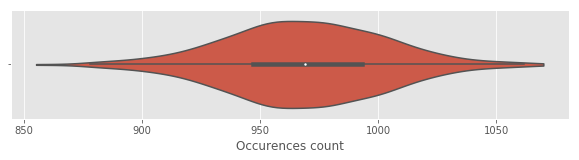

Found 4,096 kmers out of 4,096 possibilities
Median occurences: 241, Min occurences: 188, Max occurences: 302


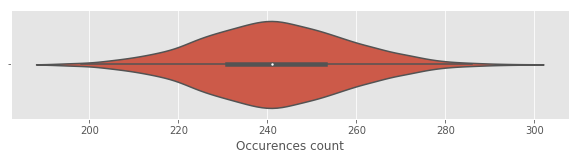

Found 16,384 kmers out of 16,384 possibilities
Median occurences: 60, Min occurences: 35, Max occurences: 93


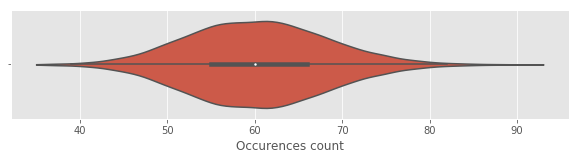

Found 65,536 kmers out of 65,536 possibilities
Median occurences: 15, Min occurences: 3, Max occurences: 35


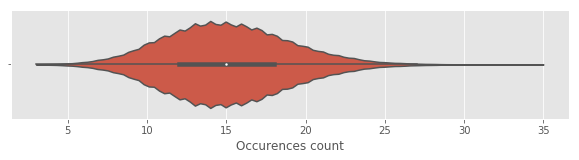

Found 255,791 kmers out of 262,144 possibilities
Median occurences: 4, Min occurences: 1, Max occurences: 16


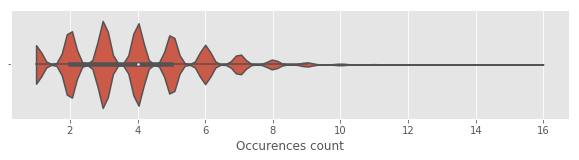

Found 564,772 kmers out of 1,048,576 possibilities
Median occurences: 1, Min occurences: 1, Max occurences: 14


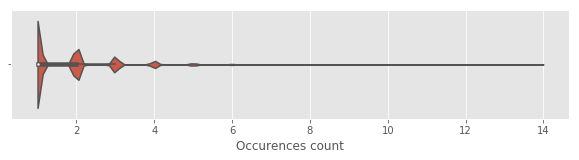

Found 745,293 kmers out of 4,194,304 possibilities
Median occurences: 1, Min occurences: 1, Max occurences: 12


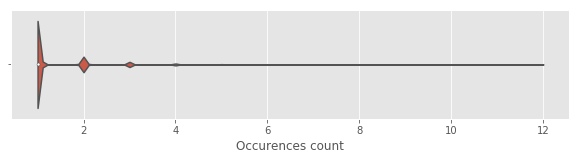

In [13]:
with pyfaidx.Fasta("./shuffle_de_bruijn_ref.fa") as fa:
    for kmer_len in range(5,12):
        jprint (f"Kmer of length {kmer_len}", bold=True)
        c = Counter()
        l = []
        for seq in fa:
            seq = str(seq)
            for i in range(0, len(seq)-kmer_len+1):
                c[seq[i:i+kmer_len]]+=1       
        print ("Found {:,} kmers out of {:,} possibilities".format(len(c), pow(4,kmer_len)))
        
        l = []
        for i in c.values():
            l.append(i)
        print ("Median occurences: {:,}, Min occurences: {:,}, Max occurences: {:,}".format(int(np.median(l)),np.min(l),np.max(l)))
        
        with pl.style.context("ggplot"):
            fig, ax = pl.subplots(figsize=(10,2))
            sns.violinplot(x=l, ax=ax, orient="h", cut=0)
            ax.set_xlabel("Occurences count")
            pl.show()
        